In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [ ]:
np.random.seed(500)
# corpus = pd.read_csv('gdrive/MyDrive/Colab Notebooks/event_timeline_generation/CWAL.csv')
# corpus = corpus[['Sentences Disassembled', 'tag']]
corpus = pd.read_csv('gdrive/MyDrive/Colab Notebooks/event_timeline_generation/random_event_data.csv')
# corpus = corpus[['sentence', 'tag']]
# corpus.columns = ['sentence', 'tag']

corpus.sentence = corpus.sentence.astype(str)
corpus['isEvent'] = corpus['isEvent'].fillna(0)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.head()
# df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Quote Generation/sentence_labels.csv')
# df = df[['sentence', 'label', 'Unnamed: 2']]
# df = df.rename(columns={'Unnamed: 2': 'label2', 'label': 'label1'})
# # df.head()
# # df.columns = ['sentence', 'label1', 'label2', 'label3']
# df['sentence'] = df['sentence'].astype(str)
# df['label1'] = df['label1'].fillna(0)
# df['label2'] = df['label2'].fillna(0)
# label1 = df['label1'].astype(int)
# label2 = df.label2.astype(int)
# new_corpus = corpus.loc[(corpus.label1==1) & (corpus.label2==1)]
# new_corpus.head()

,sentence,isEvent
0,"For, according to the science of satyagraha, t...",0.0
1,"If you say, as you have said, that the civil d...",0.0
2,"As it is, I cannot conceive a more favourable ...",0.0
3,Though I hold the British rule in India to be ...,0.0
4,"If, however, my plan itself does not appeal to...",0.0


In [ ]:
corpus.sentence.values

In [ ]:

# label = [1 if (int(x) & int(y)) else 0 for x,y in zip(label1, label2)]

# corpus = pd.DataFrame({'sentence':df.sentence.values, 'label': label})

# corpus.to_csv('gdrive/MyDrive/Colab Notebooks/Quote Generation/quotes.csv')
# corpus.head(20)

,sentence,label
0,He will not look at the external form.,0
1,I was taken out only twice a day for exercise.,0
2,It was only once that we had to carry the woun...,0
3,The English and the Dutch were of course cousins.,0
4,In the meantime a Meman firm from Porbandar wr...,0
5,"It will cast us into prison, confiscate our pr...",0
6,"Our worldly attachments diminish, and the evil...",0
7,Both had Hindu and Muslim subjects.,0
8,My life was certainly more truthful and my so...,0
9,A petition backed by force is a petition from ...,1


In [ ]:
# import nltk
# nltk.download('punkt')
# corpus['sentence_tokenized'] = [entry.lower() for entry in corpus['sentence']]

# corpus['sentence_tokenized']= [word_tokenize(entry) for entry in corpus['sentence_tokenized']]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# corpus['sentence_tokenized'] = [corpus['sentence_tokenized']]
# corpus.sentence_tokenized

0       [he, will, not, look, at, the, external, form, .]
1       [i, was, taken, out, only, twice, a, day, for,...
2       [it, was, only, once, that, we, had, to, carry...
3       [the, english, and, the, dutch, were, of, cour...
4       [in, the, meantime, a, meman, firm, from, porb...
                              ...                        
3672    [i, knew, the, proprietor, of, the, restaurant...
3673    [again, ,, one, must, show, the, certificate, ...
3674    [no, one, would, like, to, bend, a, whole, com...
3675    [he, analyzed, for, me, the, characters, of, a...
3676    [corporate, ahimsa, between, friends, is, also...
Name: sentence_tokenized, Length: 3677, dtype: object

**Fine tuning Bert**

In [ ]:
!pip install transformers==3.0.0

     |████████████████████████████████| 754 kB 13.8 MB/s 
     |████████████████████████████████| 895 kB 40.0 MB/s 
     |████████████████████████████████| 3.0 MB 40.4 MB/s 
     |████████████████████████████████| 1.2 MB 38.8 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
# np.random.seed(500)
# # corpus = pd.read_csv('gdrive/MyDrive/Colab Notebooks/event_timeline_generation/Aditya_CWAL.csv')
# # corpus = corpus[['Sentences Disassembled', 'tag']]
# corpus = pd.read_csv('gdrive/MyDrive/Colab Notebooks/event_timeline_generation/letters_annotated.csv')
# corpus = corpus[['sentence', 'tag']]
# # corpus.columns = ['sentence', 'tag']
# corpus.sentence = corpus.sentence.astype(str)
# corpus['tag'] = corpus['tag'].fillna('Other')
# corpus.head()

,sentence,tag
0,"LETTER TO VICEROY [May 4, 1930]1 DEAR FRIEND, ...",Other
1,to set out for Dharasana and reach there with ...,Other
2,and demand possession of the Salt Works.,Other
3,The public have been told that Dharasana is pr...,fact
4,This is mere camouflage.,Other


In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(corpus['sentence'], corpus['isEvent'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=corpus['isEvent'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.6, 
                                                                stratify=temp_labels)

In [ ]:
train_text.shape, val_text.shape, test_text.shape

((350,), (60,), (90,))

In [ ]:
val_text

1410    The base-hospital was always situated near a r...
388     If the present company was going to assure him...
3612                She felt quite at home on  horseback.
3283    More caution and perhaps more restraint  are n...
1611         My point is that their desire was fulfilled.
                              ...                        
1081    Are they not supposed to believe in eye for- a...
1002    When Ritch went to England, I called Polak fro...
34      An Englishman wrote in a leading newspaper a p...
100     This much I can say from my personal experienc...
695     It has always been impossible for me to reconc...
Name: sentence, Length: 441, dtype: object

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

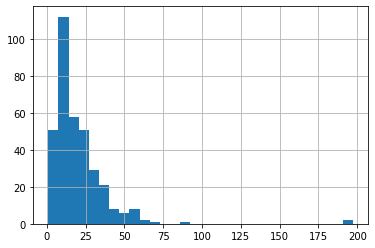

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_length = 32
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_length,
    padding='longest',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_length,
    padding='longest',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_length,
    padding='longest',
    truncation=True
)

In [ ]:
## convert lists to tensors
from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(train_labels)
Val_Y = Encoder.fit_transform(val_labels)
Test_Y = Encoder.fit_transform(test_labels)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(Train_Y.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(Val_Y.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(Test_Y.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5)          # learning rate

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(np.unique(train_labels))
print("Class Weights:",class_weights)

[0. 1.]
Class Weights: [0.66539924 2.01149425]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 200

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()



In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        68
           1       0.65      0.68      0.67        22

    accuracy                           0.83        90
   macro avg       0.77      0.78      0.78        90
weighted avg       0.84      0.83      0.83        90



*test on new data*

In [ ]:

pred_corpus = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/event_timeline_generation/news-tls data/CWAL/letters/CWAL_letters_tls.csv')
# pred_corpus.head()

pred_corpus.sentence = pred_corpus.sentence.astype(str)


max_length = 32
# tokenize and encode sequences in the test set
tokens_pred = tokenizer.batch_encode_plus(
    pred_corpus.sentence.tolist(),
    max_length = max_length,
    padding='longest',
    truncation=True
)


pred_seq = torch.tensor(tokens_pred['input_ids'])
pred_mask = torch.tensor(tokens_pred['attention_mask'])


#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(pred_seq.to(device), pred_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)

preds
# final_df = pd.concat(pred_corpus, [pd.Series(preds)], axis = 1)



array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
print(len(preds))

1387


In [ ]:
pred_corpus['isEvent'] = pd.Series(preds)
# pred_corpus.head()

events_data = pred_corpus.loc[pred_corpus.isEvent == 1]
events_data.head()
events_data.to_csv('/content/gdrive/MyDrive/Colab Notebooks/event_timeline_generation/news-tls data/CWAL/letters/CWAL_letters_event_data_new.csv')

In [ ]:
events_data.shape

(305, 7)

In [ ]:
# !cp saved_weights.pt /content/gdrive/MyDrive/Colab\ Notebooks/event_timeline_generation/news-tls\ data/